In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
# Load cleaned dataset
file_path = "dataset/cleaned_creditcard.csv"
df = pd.read_csv(file_path)

# Separate features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Reshape for LSTM (batch_size, sequence_length, num_features)
X_lstm = X_tensor.view(X_tensor.shape[0], 1, X_tensor.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [4]:
# Define simple LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out[:, -1, :])  # Take last time step
        return self.sigmoid(x)

# Train LSTM Model with Loss Visualization
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate
        model.eval()
        y_pred_test = []
        y_true_test = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch).squeeze()
                y_pred_test.extend(y_pred.numpy())
                y_true_test.extend(y_batch.numpy())

        auc = roc_auc_score(y_true_test, y_pred_test)
        print(f"Epoch {epoch+1}/{epochs} - AUC: {auc:.4f} - Loss: {avg_loss:.4f}")

    # Plot Loss Curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), train_losses, marker='o', linestyle='-', color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()

# Evaluate Model with More Visualizations
def evaluate_model(model, test_loader, model_name="LSTM"):
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch).squeeze()
            y_pred_test.extend(y_pred.numpy())
            y_true_test.extend(y_batch.numpy())

    auc = roc_auc_score(y_true_test, y_pred_test)
    print(f"{model_name} Model AUC: {auc:.4f}")

    # Confusion Matrix
    y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred_test]
    cm = confusion_matrix(y_true_test, y_pred_binary)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true_test, y_pred_test)
    plt.figure(figsize=(8,5))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC: {auc:.4f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true_test, y_pred_test)
    plt.figure(figsize=(8,5))
    plt.plot(recall, precision, color='green', label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()





Epoch 1/10 - AUC: 0.9646 - Loss: 0.0150
Epoch 2/10 - AUC: 0.9723 - Loss: 0.0026
Epoch 3/10 - AUC: 0.9785 - Loss: 0.0024
Epoch 4/10 - AUC: 0.9787 - Loss: 0.0022
Epoch 5/10 - AUC: 0.9769 - Loss: 0.0020
Epoch 6/10 - AUC: 0.9719 - Loss: 0.0018
Epoch 7/10 - AUC: 0.9741 - Loss: 0.0016
Epoch 8/10 - AUC: 0.9662 - Loss: 0.0015
Epoch 9/10 - AUC: 0.9665 - Loss: 0.0014
Epoch 10/10 - AUC: 0.9573 - Loss: 0.0012


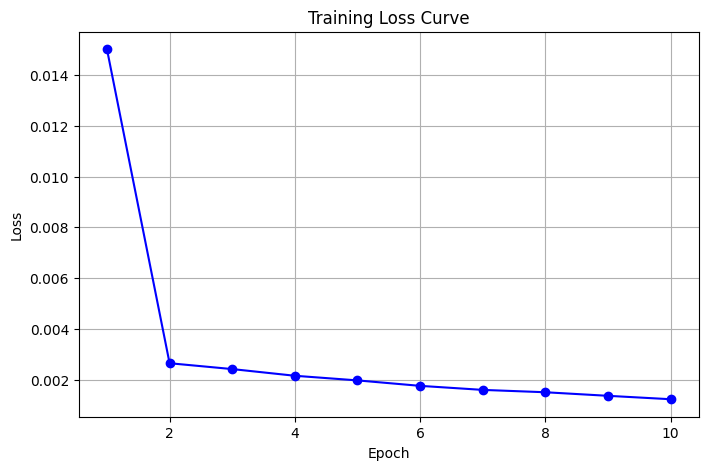

Model saved to models/lstm_model.pth
LSTM Model AUC: 0.9573


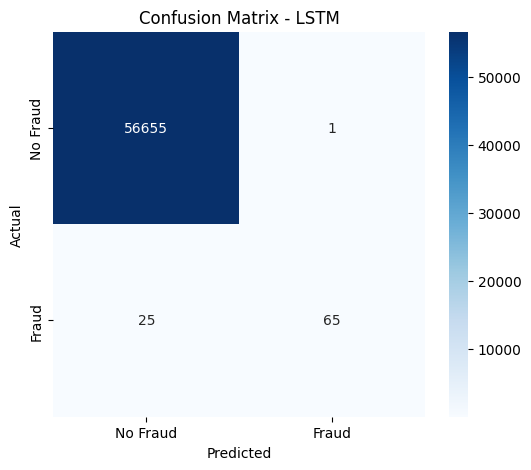

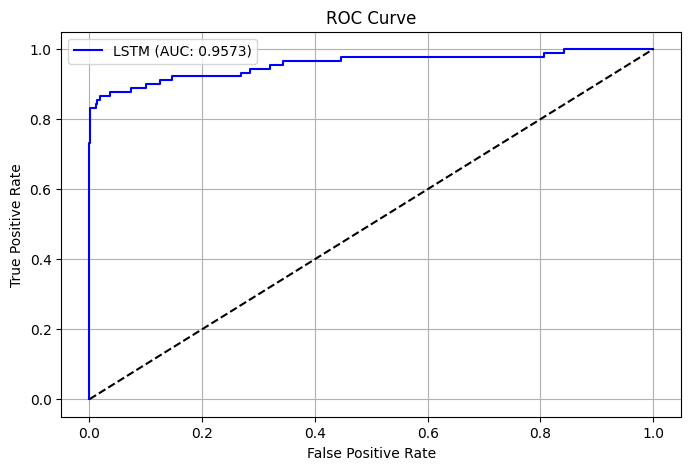

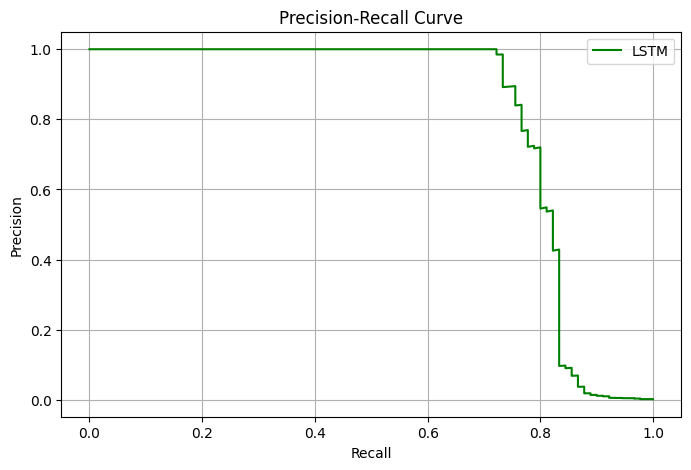

In [5]:
# Train LSTM Model
lstm_model = LSTMModel(input_size=X.shape[1])
train_model(lstm_model, train_loader, test_loader, epochs=10)

# Save the trained model
model_path = "models/lstm_model.pth"
torch.save(lstm_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Evaluate LSTM Model with Enhanced Visualization
evaluate_model(lstm_model, test_loader, "LSTM")